<a href="https://colab.research.google.com/github/harshitbhavnani/Emotion-Recognition-for-Tweets/blob/main/Source%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing required Libraries**

In [ ]:
import pandas as pd
import numpy as np

import re
import os

import textblob

import nltk
nltk.download('all')

from sklearn.linear_model import LinearRegression as LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

**Loading the Dataset**

In [ ]:
!unzip '/content/SemEval2018-Task1-all-data.zip'

In [ ]:
anger_train = pd.read_csv('/content/SemEval2018-Task1-all-data/English/EI-reg/training/EI-reg-En-anger-train.txt', sep='\t',encoding='utf8')
joy_train = pd.read_csv('/content/SemEval2018-Task1-all-data/English/EI-reg/training/EI-reg-En-joy-train.txt',sep='\t',encoding='utf8')
fear_train = pd.read_csv('/content/SemEval2018-Task1-all-data/English/EI-reg/training/EI-reg-En-fear-train.txt',sep='\t',encoding='utf8')
sadness_train = pd.read_csv('/content/SemEval2018-Task1-all-data/English/EI-reg/training/EI-reg-En-sadness-train.txt',sep='\t',encoding='utf8')

anger_dev = pd.read_csv('/content/SemEval2018-Task1-all-data/English/EI-reg/development/2018-EI-reg-En-anger-dev.txt', sep='\t',encoding='utf8')
joy_dev = pd.read_csv('/content/SemEval2018-Task1-all-data/English/EI-reg/development/2018-EI-reg-En-joy-dev.txt',sep='\t',encoding='utf8')
fear_dev = pd.read_csv('/content/SemEval2018-Task1-all-data/English/EI-reg/development/2018-EI-reg-En-fear-dev.txt',sep='\t',encoding='utf8')
sadness_dev = pd.read_csv('/content/SemEval2018-Task1-all-data/English/EI-reg/development/2018-EI-reg-En-sadness-dev.txt',sep='\t',encoding='utf8')

In [ ]:
anger = pd.concat([anger_train,anger_dev])
sadness = pd.concat([sadness_train,sadness_dev])
joy = pd.concat([joy_train,joy_dev])
fear = pd.concat([fear_train,fear_dev])

In [ ]:
print(anger_train.shape)
print(sadness_train.shape)
print(joy_train.shape)
print(fear_train.shape)

print(anger_dev.shape)
print(sadness_dev.shape)
print(joy_dev.shape)
print(fear_dev.shape)

(1701, 4)
(1533, 4)
(1616, 4)
(2252, 4)
(388, 4)
(397, 4)
(290, 4)
(389, 4)


# **Data Preprocessing**

The function below cleans the data by removing:

1. Tagged Accounts
2. Links
3. Removing Empty/Duplicate Tweet
4. Punctuation marks and Special Characters
5. Stopwords
6. NA Values

In [ ]:
def data_cleaning(df):

  from nltk.corpus import stopwords
  
  def remove_pattern(text):
    pattern_regex = "(?:@[\w_]+)"
    r = re.findall(pattern_regex, text)
    for i in r:
      text = re.sub(i,'', text)
    return text

  df['Tweet'] = np.vectorize(remove_pattern)(df['Tweet'])
  
  cleaned_tweets = []

  for index, row in df.iterrows():
    words_without_links = [word for word in row.Tweet.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))
  df['Tweet'] = cleaned_tweets

  df = df[df['Tweet']!='']
  df = df.drop_duplicates(subset=['Tweet'], keep=False)

  df['Tweet'] = df['Tweet'].str.replace("[^a-zA-Z# ]", "")

  stopwords = set(stopwords.words("english"))
  stopwords_set = set(stopwords)
  cleaned_tweets = [] 
  for index, row in df.iterrows():
    words_without_stopwords = [word for word in row.Tweet.split() if not word in stopwords_set and '#' not in word.lower()]
    cleaned_tweets.append(' '.join(words_without_stopwords))
  df['Tweet'] = cleaned_tweets

  df.dropna(subset=['Tweet'], inplace=True)

  df = df.reset_index(drop=True)

  return df

In [ ]:
anger_train = data_cleaning(anger_train)
joy_train = data_cleaning(joy_train)
sadness_train = data_cleaning(sadness_train)
fear_train = data_cleaning(fear_train)

anger_dev = data_cleaning(anger_dev)
joy_dev = data_cleaning(joy_dev)
sadness_dev = data_cleaning(sadness_dev)
fear_dev = data_cleaning(fear_dev)

Tokenization, Lametization and Concatenation of tokens to form sentences

In [ ]:
def data_preparation(df):

  from nltk.stem import WordNetLemmatizer
  
  df['Tweet'] = df['Tweet'].apply(lambda x: x.split())

  word_lemmatizer = WordNetLemmatizer()
  df['Tweet'] = df['Tweet'].apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])

  for i, tokens in enumerate(df['Tweet']):
    df['Tweet'][i] = ' '.join(tokens)

  return df

In [ ]:
anger_train = data_preparation(anger_train)
joy_train = data_preparation(joy_train)
sadness_train = data_preparation(sadness_train)
fear_train = data_preparation(fear_train)

anger_dev = data_preparation(anger_dev)
joy_dev = data_preparation(joy_dev)
sadness_dev = data_preparation(sadness_dev)
fear_dev = data_preparation(fear_dev)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Feature Extraction & Vectorization - Extracting Key Phrases and using TF-IDF (Term Frequency - Inverse Document Frequency) Vectorizer

In [ ]:
def key_phrase_extraction(df):

  from textblob.np_extractors import ConllExtractor

  textblob_key_phrases = []
  extractor = ConllExtractor()

  for index, row in df.iterrows():

    words_without_hash = [word for word in row.Tweet.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = textblob.TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))
    
  df['key_phrases'] = textblob_key_phrases
  df = df[df['key_phrases'].str.len()>0]

  textblob_key_phrases = []
  blob = []
  hash_removed_sentence = []
  words_without_hash = []

  return df

In [ ]:
anger_train = key_phrase_extraction(anger_train)
joy_train = key_phrase_extraction(joy_train)
sadness_train = key_phrase_extraction(sadness_train)
fear_train = key_phrase_extraction(fear_train)

anger_dev = key_phrase_extraction(anger_dev)
joy_dev = key_phrase_extraction(joy_dev)
sadness_dev = key_phrase_extraction(sadness_dev)
fear_dev = key_phrase_extraction(fear_dev)

In [ ]:
anger_y_train = anger_train['Intensity Score']
joy_y_train = joy_train['Intensity Score']
sadness_y_train = sadness_train['Intensity Score']
fear_y_train = fear_train['Intensity Score']

anger_y_dev = anger_dev['Intensity Score']
joy_y_dev = joy_dev['Intensity Score']
sadness_y_dev = sadness_dev['Intensity Score']
fear_y_dev = fear_dev['Intensity Score']

In [ ]:
!brew install wget
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz

/bin/bash: brew: command not found
--2021-10-23 06:26:44--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.103.216
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.103.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  15.4MB/s    in 1m 42s  

2021-10-23 06:28:27 (15.4 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
import gensim.models
Vec = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin', binary=True)
model = Vec.wv
del Vec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def vectorizer(df):
  feat = []
  for i in range(len(df)):
    f = []
    d = df[i]
    temp = []
    for w in d:
      if w in model:
        temp.append(model[w])
    if len(temp) == 0:
      temp.append(model['cat'])
    f = list(((np.array(temp)).mean(0)))
    f += list((np.median((np.array(temp)), 0)))
    f += list((np.array(temp)).max(0))
    f += list((np.array(temp)).min(0))
    f += list((np.percentile(temp, 25, 0)))
    f += list((np.percentile(temp, 75, 0)))
    n = [len(k) for k in d]
    f.append(len(d))
    f.append(sum(n))
    f.append(sum(n) / len(d))
    feat.append(f)
  feat = np.array(feat)
  feat = np.reshape(feat, (len(df), 1803))
  return feat

In [ ]:
anger_train_vec = vectorizer(anger_train['key_phrases'].to_numpy())
joy_train_vec = vectorizer(joy_train['key_phrases'].to_numpy())
sadness_train_vec = vectorizer(sadness_train['key_phrases'].to_numpy())
fear_train_vec = vectorizer(fear_train['key_phrases'].to_numpy())

anger_dev_vec = vectorizer(anger_dev['key_phrases'].to_numpy())
joy_dev_vec = vectorizer(joy_dev['key_phrases'].to_numpy())
sadness_dev_vec = vectorizer(sadness_dev['key_phrases'].to_numpy())
fear_dev_vec = vectorizer(fear_dev['key_phrases'].to_numpy())

# **Machine Learning Models**

LR, Random Forest, Naive Bayes, SVM, KNN - MSE, RMSE, R2,  Adjusted R2, MAPE, AMAPE

In [ ]:
LinearRegression = LinearRegression()
RandomForest = RandomForestRegressor(random_state=10)
GradientBoost = GradientBoostingRegressor(random_state=10)
DecisionTree = DecisionTreeRegressor(random_state=10)
KNN = KNeighborsRegressor()
SVR = SVR()

In [ ]:
def predictions(X_train, y_train, X_dev, y_dev):

  scores = pd.DataFrame(columns=['Linear Regression','Random Forest',
                               'Decision Tree','KNN', 'SVR',
                               'GradientBoost'],
                      index=['R2','MAE','MSE','RMSE'])

  LinearRegression.fit(X_train,y_train)
  RandomForest.fit(X_train,y_train)
  DecisionTree.fit(X_train,y_train)
  KNN.fit(X_train,y_train)
  SVR.fit(X_train,y_train)
  GradientBoost.fit(X_train,y_train)

  y_pred = [None]*6

  y_pred[0] = LinearRegression.predict(X_dev)
  y_pred[1] = RandomForest.predict(X_dev)
  y_pred[2] = DecisionTree.predict(X_dev)
  y_pred[3] = KNN.predict(X_dev)
  y_pred[4] = SVR.predict(X_dev)
  y_pred[5] = GradientBoost.predict(X_dev)

  for i in range(6):
    scores.iloc[0][i]=r2_score(y_dev, y_pred[i])
    scores.iloc[1][i]=mean_absolute_error(y_dev, y_pred[i])
    scores.iloc[2][i]=mean_squared_error(y_dev, y_pred[i])
    scores.iloc[3][i]=mean_squared_error(y_dev, y_pred[i], squared=False)

  return scores

In [ ]:
score_anger = predictions(anger_train_vec, anger_y_train, anger_dev_vec, anger_y_dev)
score_joy = predictions(joy_train_vec, joy_y_train, joy_dev_vec, joy_y_dev)
score_sadness = predictions(sadness_train_vec, sadness_y_train, sadness_dev_vec, sadness_y_dev)
score_fear = predictions(fear_train_vec, fear_y_train, fear_dev_vec,fear_y_dev)

In [ ]:
score_anger

,Linear Regression,Random Forest,Decision Tree,KNN,SVR,GradientBoost
R2,-7.3828e+21,-0.0788643,-0.182579,-0.140585,-0.0153836,-0.0223897
MAE,3.48474e+09,0.170682,0.177707,0.17367,0.165721,0.16674
MSE,2.92349e+20,0.0427216,0.0468286,0.0451657,0.0402079,0.0404853
RMSE,1.70982e+10,0.206692,0.216399,0.212522,0.200519,0.20121


In [ ]:
score_joy

,Linear Regression,Random Forest,Decision Tree,KNN,SVR,GradientBoost
R2,-1.96711e+22,-0.0910428,-0.159834,-0.384159,-0.0149771,-0.0109779
MAE,3.18182e+09,0.162775,0.167744,0.182052,0.161567,0.159749
MSE,7.22398e+20,0.0400672,0.0425935,0.0508316,0.0372738,0.0371269
RMSE,2.68775e+10,0.200168,0.206382,0.225459,0.193064,0.192684


In [ ]:
score_sadness

,Linear Regression,Random Forest,Decision Tree,KNN,SVR,GradientBoost
R2,-6.71138e+21,-0.106157,-0.207057,-0.236501,-0.00589185,-0.0225636
MAE,3.14869e+09,0.153242,0.159843,0.161546,0.146084,0.147382
MSE,2.18221e+20,0.0359667,0.0392475,0.0402049,0.0327066,0.0332487
RMSE,1.47723e+10,0.189649,0.19811,0.200511,0.18085,0.182342


In [ ]:
score_fear

,Linear Regression,Random Forest,Decision Tree,KNN,SVR,GradientBoost
R2,-5.0432e+21,-0.161456,-0.227915,-0.209392,-0.0226743,-0.0947355
MAE,2.50807e+09,0.151374,0.155281,0.156681,0.144375,0.147129
MSE,1.58992e+20,0.036616,0.0387112,0.0381272,0.0322408,0.0345126
RMSE,1.26092e+10,0.191353,0.196752,0.195262,0.179557,0.185776


# Exploratory Data Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 25 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

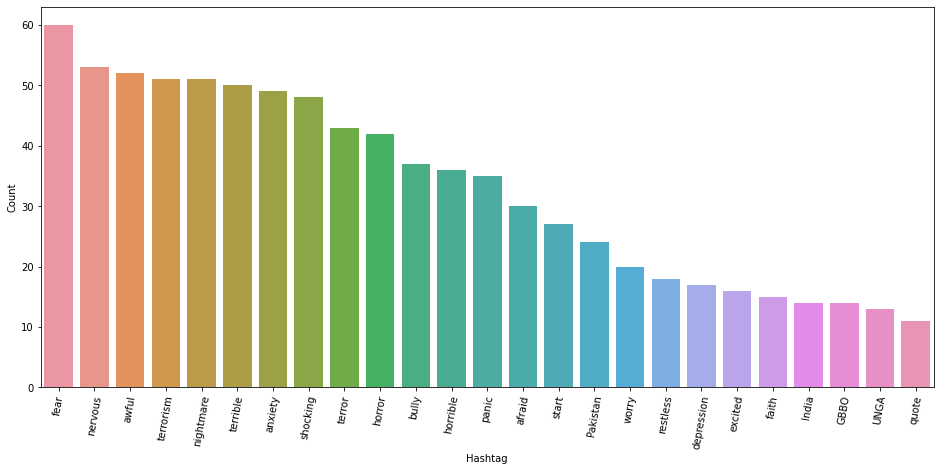

In [ ]:
hashtags = hashtag_extract(fear['Tweet'])
hashtags = sum(hashtags, [])
generate_hashtag_freqdist(hashtags)

In [ ]:
from wordcloud import WordCloud

anger = data_cleaning(anger)
joy = data_cleaning(joy)
sadness = data_cleaning(sadness)
fear = data_cleaning(fear)

anger = data_preparation(anger)
joy = data_preparation(joy)
sadness = data_preparation(sadness)
fear = data_preparation(fear)


def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


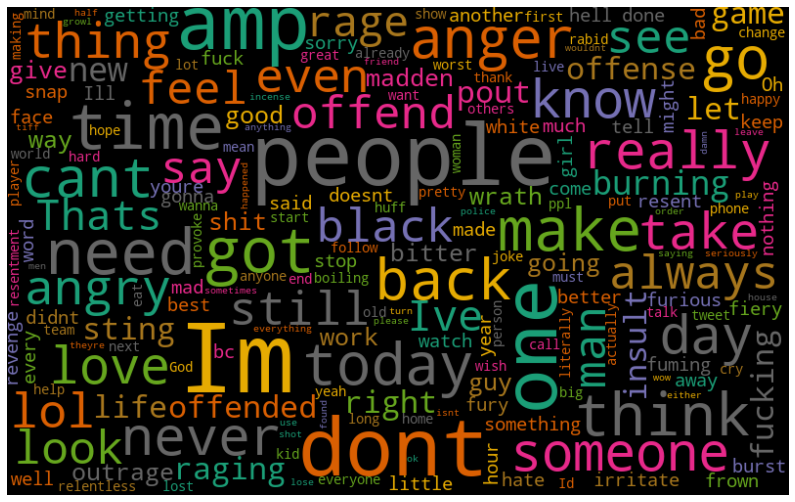

In [ ]:
generate_wordcloud(' '.join([text for text in anger['Tweet']]))

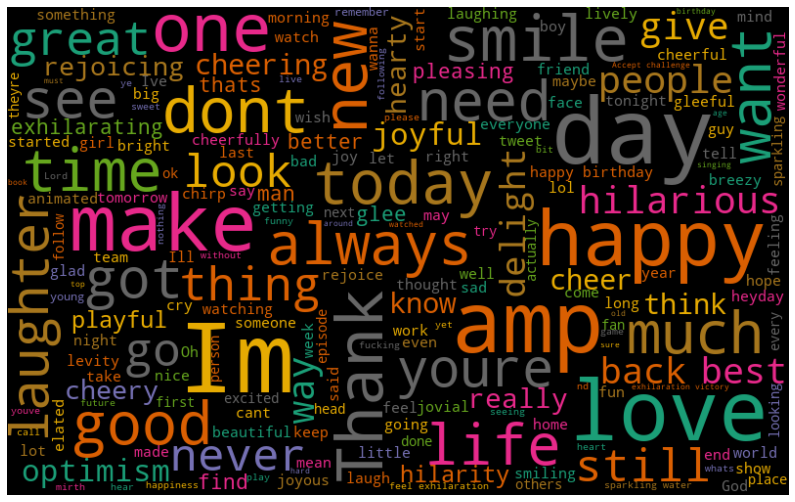

In [ ]:
generate_wordcloud(' '.join([text for text in joy['Tweet']]))

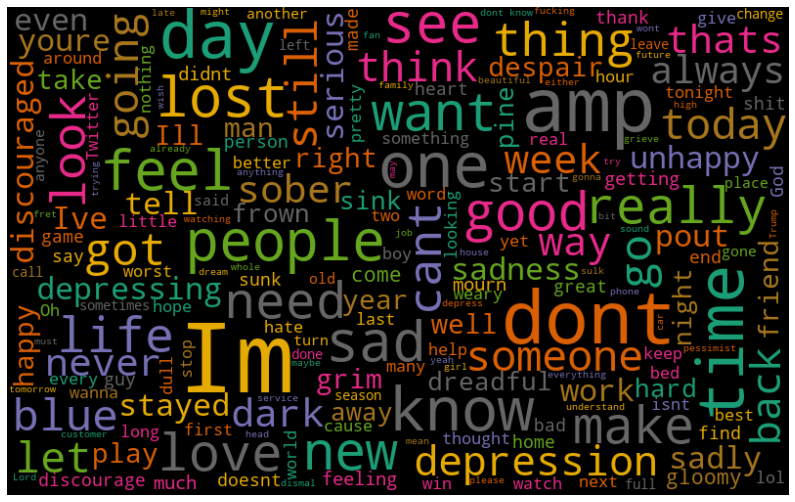

In [ ]:
generate_wordcloud(' '.join([text for text in sadness['Tweet']]))

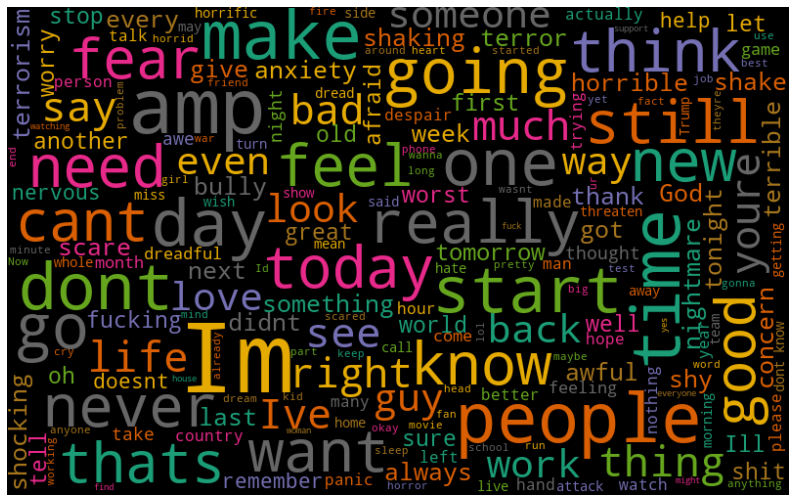

In [ ]:
generate_wordcloud(' '.join([text for text in fear['Tweet']]))

# **Flask App**

In [ ]:
!pip install flask gevent requests pillow

!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask

In [ ]:
procfile = 'web: gunicorn app:app'
procfiles= open("/content/Procfile","w")
procfiles.write(procfile)
procfiles.close()

In [ ]:
a =  """<html>
    <head>
        <title>{{ title }} Capstone Project </title>
        <link rel="stylesheet" type="text/css" href="{{ url_for('static', filename='style.css') }}">
    </head>
    <body>
        <h1>Welcome To the Emotion Recognition Tool</h1>
        <form method="POST">
            <textarea name="text1" placeholder="Please Enter Your Tweet Here..." rows="10" cols="109"></textarea><br><br>

            <input class="example_a" type="submit">
        </form>
        <div>
            <img src="data:image/png;base64, {{ image_b64 }}">
        </div>
        <span>by Harshit Bhavnani</span>
    </body>
</html>"""

In [ ]:
!mkdir '/content/templates'
!mkdir '/content/uploads'

Html_file = open("/content/templates/form.html", "w")
Html_file.write(a)
Html_file.close()

In [ ]:
text = '#Our #DataScience program is #awesome. I have had an absolutely great time studying in the department. Although it has been challenging and the subjects have been tough, it has greatly rewarded me in terms of the #amazing and novel skills that I have learnt.'

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://3560-35-236-129-170.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [23/Oct/2021 08:01:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2021 08:01:53] "GET /static/style.css HTTP/1.1" 404 -
127.0.0.1 - - [23/Oct/2021 08:01:54] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/Oct/2021 08:01:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2021 08:01:57] "GET /static/style.css HTTP/1.1" 404 -


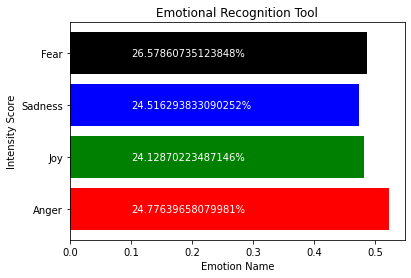

127.0.0.1 - - [23/Oct/2021 08:04:15] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2021 08:04:16] "GET /static/style.css HTTP/1.1" 404 -


In [ ]:
import os
from flask import Flask, render_template, request, url_for, redirect
import base64

app = Flask(__name__)
run_with_ngrok(app)
app.config['UPLOADS'] = 'uploads'

def predict_values(text):
  
  import matplotlib.pyplot as plt
  from matplotlib.pyplot import figure
  
  t = [text]
  text = pd.DataFrame(t, columns = ['Tweet'])
  text = data_cleaning(text)
  text = data_preparation(text)
  text = key_phrase_extraction(text)
  text = vectorizer(text['key_phrases'].to_numpy())

  from sklearn.svm import SVR
  SVR = SVR()
  SVR.fit(anger_train_vec,anger_y_train)
  anger_pred = SVR.predict(text)
  
  from sklearn.svm import SVR
  SVR = SVR()
  SVR.fit(sadness_train_vec,sadness_y_train)
  sadness_pred = SVR.predict(text) 
  
  from sklearn.svm import SVR
  SVR = SVR()
  SVR.fit(fear_train_vec,fear_y_train)
  fear_pred = SVR.predict(text)

  from sklearn.ensemble import GradientBoostingRegressor
  GradientBoost = GradientBoostingRegressor()
  GradientBoost.fit(joy_train_vec,joy_y_train)
  joy_pred = GradientBoost.predict(text)

  array = [anger_pred[0], joy_pred[0], sadness_pred[0], fear_pred[0]]
  total = anger_pred[0] + joy_pred[0] + sadness_pred[0] + fear_pred[0]
  ang_pc = (anger_pred[0]/total)*100
  joy_pc = (joy_pred[0]/total)*100
  sad_pc = (sadness_pred[0]/total)*100
  fear_pc = (fear_pred[0]/total)*100
  array_pc = [ang_pc,joy_pc,sad_pc,fear_pc]

  for i in range(4):
    array_pc[i] = str(array_pc[i])+'%'

  fig, ax = plt.subplots()
  
  bar_plot = plt.barh(["Anger","Joy","Sadness","Fear"],
             array, align='center', color = ['red', 'green', 'blue', 'black'])
  
  for bar, array_pc in zip(ax.patches, array_pc[::-1]):
    ax.text(0.1, bar.get_y()+bar.get_height()/2, array_pc, color = 'white', ha = 'left', va = 'center') 

  plt.ylabel('Intensity Score')
  plt.xlabel('Emotion Name')
  plt.title('Emotion Recognition Tool')
  plt.savefig('image.png')
  plt.show()
  img = plt.figure()

  return img

def image_to_data_url(filename):
    ext = filename.split('.')[-1]
    with open(filename, 'rb') as f:
        img = f.read()
    return base64.b64encode(img).decode('utf-8')

@app.route('/')
def my_form():
    return render_template('form.html')

@app.route('/', methods=['POST'])
def my_form_post():
    text1 = request.form['text1']
    img = predict_values(text1)
    image_b64 = image_to_data_url('/content/image.png')

    return render_template('form.html', text1=text1, image_b64=image_b64)
  
if __name__=='__main__':
    app.run()